### Import mujoco and numpy

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [17]:
class PlanarDroneDynamics(object):
    def __init__(self, dt=0.1) -> None:
        self._m  = 0.1
        # self._I = np.diag([1.0, 1.0, 1.0])
        self._g  = 9.81 
        self._I = 0.1
        self._r = 0.1
        self._dt = dt


        def dfdt(q, tau):
            x, y, th = q[0], q[1], q[2]
            xdot, ydot, thdot = q[3], q[4], q[5]
            u1, u2 = tau[0], tau[1]
            xddot = (-(u1 + u2) * ca.sin(th))/self._m
            yddot = ((u1+u2) * ca.cos(th) - self._m * self._g)/self._m
            thddot = (self._r * (u1-u2))/self._I
            return ca.vertcat(xdot, ydot, thdot, xddot, yddot, thddot) 

        def f(x, u):
            return x + self._dt * self.dfdt(x, u)
        self.dfdt = dfdt 
        self.f = f 

model = PlanarDroneDynamics()

def loss(x, u):
    return 10*ca.sumsqr(x-np.array([0.,0., 2*np.pi,0., 0., 0.])) + 0.01*ca.sumsqr(u)

In [18]:
opti = ca.Opti()
tf = 15
N = int(tf/model._dt)
x = opti.variable(6, N+1) # Decision variables for state trajetcory
u = opti.variable(2, N)
p  = opti.parameter(6, 1)  # initial cond Parameter (not optimized over)
pf = opti.parameter(2,1)
opti.minimize(loss(x,u)/N)

for k in range(N):
  opti.subject_to(x[:,k+1]==model.f(x[:,k],u[:,k]))

opti.subject_to(opti.bounded(0,u,10))
opti.subject_to(x[:,0]==p) #np.array([2.,0.]))
# opti.subject_to(u>=0)
# opti.subject_to(x[:,-1]==pf) #np.array([10.,0.]))


In [19]:
p_opts = {"expand": True}
s_opts = {"max_iter": 1000000}
opti.solver('ipopt', p_opts, s_opts)

# And choose a concrete value for p
opti.set_value(p, [0.,0.,0.,0.,0.,0.])
# opti.set_value(pf, [1.1 ,0.])
sol = opti.solve()

This is Ipopt version 3.14.5, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     3456
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1506

Total number of variables............................:     1206
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      906
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9741607e+02 9.81e-01 8.41e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

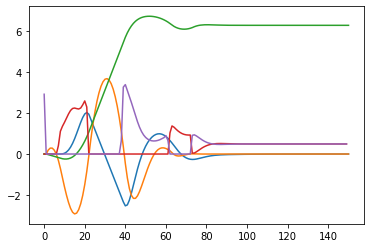

In [21]:
# plt.plot(opti.debug.value(x).T)
# plt.plot(opti.debug.value(u).T)

plt.plot(sol.value(x).T[:,:3])
plt.plot(sol.value(u).T)